<a href="https://colab.research.google.com/github/Navu45/tinkoff-dla/blob/main/tinkoff_dla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подготовка данных

In [ ]:
import torch
import random
import math
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import glob
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from skimage.io import imread
import cv2
import os.path as pth
from random import shuffle

In [ ]:
from torch.utils.data import Dataset
import torch
from torchvision.transforms import transforms
from skimage.io import imread
import cv2
import glob
import random


def onehot(label, alphabet):
    result = []
    for i in range(len(label)):
      result.append(alphabet.index(label[i]))
    return torch.LongTensor(result)


class VehiclePlateDataset(Dataset):
    def __init__(self, root,
                 train=True, train_size=0.8,
                 transform=None, image_size=(238, 90)):
        self.root = root
        self.image_size = image_size
        self.regions = []
        self.labels = []
        if train:
            self.root += 'train/'
        else:
            self.root += 'test/'

        self.file_list = glob.glob(self.root + "*")

        self.transform = transform
        if self.transform is None:
            self.transform = transforms.ToTensor()

        size = len(self.file_list) * (train_size if train else 1 - train_size)
        for i, path in enumerate(self.file_list):
            if i >= size:
                break
            filename = path.split('\\')[-1]
            label = filename.split('.')[0].split('-')[-1]
            self.labels.append([path, label])

    def labels_to_tensor(self, alphabet):
        for i in range(len(self.labels)):
            self.labels[i][-1] = onehot(self.labels[i][1], alphabet)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        filename, label = self.labels[index]
        image = imread(filename)
        image = cv2.resize(image, self.image_size)
        image = self.transform(image)
        torch._assert(not torch.isnan(image).any(), 'Dataset creates nan')  
        return image, label


In [ ]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
root = './CCPD2019-dl1/'
image_size=(512, 128)
train_dataset = VehiclePlateDataset(root, train=True, transform=data_transform, image_size=image_size)
test_dataset = VehiclePlateDataset(root, train=False, transform=data_transform, image_size=image_size)

In [ ]:
provinces = []
for path in train_dataset.file_list:
  filename = path.split('\\')[-1]
  label = filename.split('.')[0].split('-')[-1]
  if label[0] not in provinces:
    provinces.append(label[0])
  
len(provinces), provinces

(31,
 ['皖',
  '沪',
  '苏',
  '云',
  '豫',
  '京',
  '川',
  '浙',
  '湘',
  '赣',
  '渝',
  '鲁',
  '粤',
  '晋',
  '冀',
  '津',
  '闽',
  '辽',
  '鄂',
  '甘',
  '新',
  '贵',
  '陕',
  '琼',
  '桂',
  '青',
  '蒙',
  '黑',
  '吉',
  '宁',
  '藏'])

In [ ]:
alphabet = []
alphabet.extend(provinces)
alphabet.extend([str(i) for i in [i for i in range(10)]])
alphabet.extend([str(chr(i)) for i in range(0x41, 0x5b)])
alphabet

['皖',
 '沪',
 '苏',
 '云',
 '豫',
 '京',
 '川',
 '浙',
 '湘',
 '赣',
 '渝',
 '鲁',
 '粤',
 '晋',
 '冀',
 '津',
 '闽',
 '辽',
 '鄂',
 '甘',
 '新',
 '贵',
 '陕',
 '琼',
 '桂',
 '青',
 '蒙',
 '黑',
 '吉',
 '宁',
 '藏',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

In [ ]:
train_dataset.labels_to_tensor(alphabet)
test_dataset.labels_to_tensor(alphabet)

In [ ]:
train_dataset.labels[500]

['./CCPD2019-dl1/train\\00413793103448-皖AGB070.jpg',
 tensor([ 0, 41, 47, 42, 31, 38, 31])]

In [ ]:
batch_size = 12

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=True,  batch_size=batch_size, pin_memory=True)

In [ ]:
def output_images(images, n = 1):
  plt.figure(figsize=(20, 10))
  s = 1 if n == 1 else n // 2
  for i in range(n):
    plt.subplot(s, s, i + 1)
    image = images[i].detach().cpu()
    plt.imshow((np.array(image) * 255).astype(np.uint8), interpolation='nearest')
  plt.show()

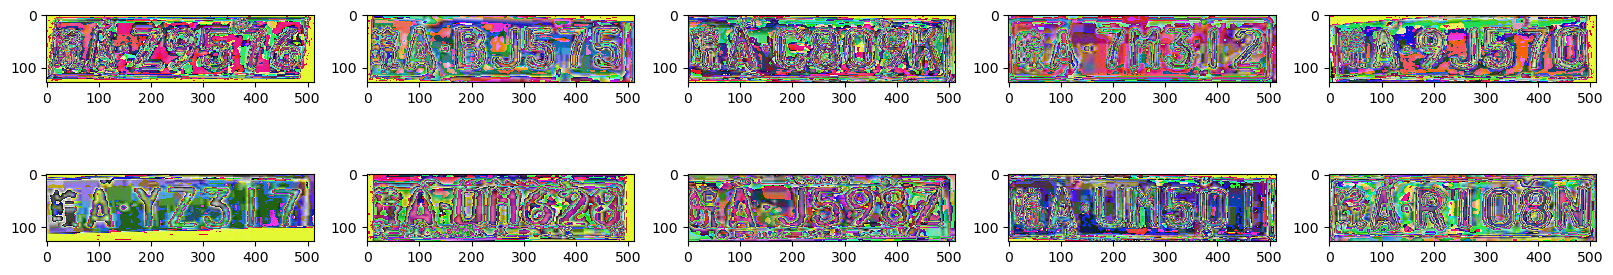

In [ ]:
output_images(next(iter(train_loader))[0].permute(0, 2, 3, 1), 10)

# Создание и обучение модели

In [ ]:
import pytorch_lightning as pl

Посчитаем количество символов в алфавите: 
*   31 (`len(provinces`) - каждая провинция Китая, упомянутая на знаках, выше был цикл, который сохраняет все уникальные иероглифы в список
*   10 цифр
*   26 букв английского алфавита



In [ ]:
n_classes = len(provinces) + 10 + 26
n_classes

67

В задании дана архитектура CRNN (Convolutional recurrent neural network), поэтому для реализации архитектуры использовалась оригинальная статься CRNN.

Для слоя CNN написан класс Backbone, для рекуррентных - BiLTSM. Обе части собираются в классе CRNN.

https://medium.com/swlh/multi-digit-sequence-recognition-with-crnn-and-ctc-loss-using-pytorch-framework-269a7aca2a6 - отличная статься по CRNN

https://arxiv.org/pdf/1507.05717.pdf - еще одна работа про OCR и Image-based sequence recognition 

In [ ]:
def conv_block(in_channels, out_channels, pooling_size):
  return nn.Sequential(
      nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                           kernel_size=3, padding=1),
      nn.LeakyReLU(0.2, inplace=True),
      nn.InstanceNorm2d(out_channels),
      nn.MaxPool2d(*pooling_size)
  )

In [ ]:
class Backbone(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Backbone, self).__init__()
    self.sizes = [
        (3, 64, ((2, 2))),
        (64, 128, ((2, 2))),
        (128, 256, ((2, 2))),
        (256, 256, ((2, 2))),
        (256, 512, ((2, 2))),
        (512, 512, ((2, 2), (2, 1), (0, 1))),
        (512, 512, ((2, 2), (2, 1), (0, 1))),

    ]
    self.block = nn.Sequential(*[
        conv_block(*size) for i, size in enumerate(self.sizes)
    ])
  
  def forward(self, x):
    return self.block(x)

In [ ]:
class BiLSTM(nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels):
      super(BiLSTM, self).__init__()
      self.lstm = nn.LSTM(in_channels, hidden_channels, bidirectional=True)
      self.embedding = nn.Linear(hidden_channels * 2, out_channels)

  def forward(self, x):
      recurrent, _ = self.lstm(x)
      T, b, h = recurrent.size()
      t_rec = recurrent.view(T * b, h)

      output = self.embedding(t_rec) 
      output = output.view(T, b, -1)

      return output

In [ ]:
input_lengths = torch.full(size=(batch_size,), fill_value=18, dtype=torch.long)
target_lengths = torch.full(size=(batch_size,), fill_value=7, dtype=torch.long)

In [ ]:
from itertools import groupby

In [ ]:
class CRNN(pl.LightningModule):
  def __init__(self, in_channels, hidden_channels, n_classes, blank_label=0):
    super(CRNN, self).__init__()
    self.save_hyperparameters()
    self.cnn = Backbone(in_channels, hidden_channels)
    self.rnn = nn.Sequential(
      BiLSTM(hidden_channels, hidden_channels, hidden_channels),
      BiLSTM(hidden_channels, hidden_channels, n_classes)
    )
    self.cnn_output_height = 18 # cnn_output_width is equal to 1
    self.softmax = nn.LogSoftmax(dim=2)
    self.loss_function = nn.CTCLoss(blank=blank_label, reduction='mean', zero_infinity=True)

    self.train_correct = 0
    self.train_total = 0

  def forward(self, x):
    conv = self.cnn(x)
    b, c, h, w = conv.size()  
    assert h == 1, "the height of conv must be 1"
    conv = conv.squeeze(2)
    x = conv.permute(2, 0, 1).contiguous()
    output = self.rnn(x)
    # print(x.size(), output.size())
    return self.softmax(output)

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    return optimizer

  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    output = self(x)
    # print(output.size())
    loss = self.loss_function(output, y, input_lengths, target_lengths)
    self.log('train_loss', loss)
    _, max_index = torch.max(output, dim=2)  # max_index.shape == torch.Size([18, 12])
    for i in range(batch_size):
        raw_prediction = list(max_index[:, i].detach().cpu().numpy())  # len(raw_prediction) == 18
        prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != 0]).cuda()
        if len(prediction) == len(y[i]) and torch.all(prediction.eq(y[i])):
            self.train_correct += 1
        self.train_total += 1
    return loss 

In [ ]:
model = CRNN(3, 512, n_classes)
model

CRNN(
  (cnn): Backbone(
    (block): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_runn

In [ ]:
PATH = "./models/"

trainer = pl.Trainer(accelerator="gpu", max_epochs=1, default_root_dir=PATH, auto_lr_find=True)
trainer.fit(model, train_loader)

# Подсчет метрик

False

# Анализ ошибок модели